In [2]:
import pandas as pd

train_df = pd.read_csv(r"C:\Users\user\ML Resources-code\Machine-Learning\Deep Learning Time Series Forecasting\train.csv")

val_df = pd.read_csv(r"C:\Users\user\ML Resources-code\Machine-Learning\Deep Learning Time Series Forecasting\val.csv")

test_df = pd.read_csv(r"C:\Users\user\ML Resources-code\Machine-Learning\Deep Learning Time Series Forecasting\test.csv")

In [4]:
import tensorflow as tf

In [5]:
print(tf.__version__) 

2.17.0


In [6]:
print(train_df.shape, test_df.shape, val_df.shape)

(12285, 5) (1756, 5) (3510, 5)


In [21]:
#implement the class window as in the previous chapters 
import matplotlib.pyplot as plt
import numpy as np

class DataWindow():
    def __init__(self, input_width, label_width, shift, train_df=train_df, val_df=val_df, 
                 test_df=test_df, label_columns=None):
        self.train_df = train_df
        self.val_df = val_df
        self.test_df = test_df

        self.label_columns = label_columns
        if label_columns is not None:
            self.label_columns_indices = {name: i for i, name in enumerate(label_columns)}
        self.column_indices = {name: i for i, name in enumerate(train_df.columns)}

        self.input_width = input_width
        self.label_width = label_width  
        self.shift = shift

        self.total_window_size = input_width + shift

        self.input_slice = slice(0, input_width)
        self.input_indices = np.arange(self.total_window_size)[self.input_slice]

        self.label_start = self.total_window_size - self.label_width
        self.labels_slice = slice(self.label_start, None)   
        self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

    def split_to_inputs_labels(self, features):
        inputs = features[:, self.input_slice, :] #slice the window from the total window
        labels = features[:, self.labels_slice, :] 
        if self.label_columns is not None:
            labels = tf.stack([labels[:,:,self.column_indices[name]] for name in self.label_columns], axis=-1)
        inputs.set_shape([None, self.input_width, None])
        labels.set_shape([None, self.label_width, None])

        return inputs, labels 
    
    def plot(self, model=None, plot_col ='traffic_volume', max_subplots=3):
        inputs, labels = self.sample_batch
        plt.figure(figsize=(12, 8))
        plot_col_index = self.column_indices[plot_col]
        max_n = min(max_subplots, len(inputs))
        for n in range(max_n):
            plt.subplot(3, 1, n+1)
            plt.ylabel(f'{plot_col} [scaled]')
            plt.plot(self.input_indices, inputs[n, :, plot_col_index],
                     label='Inputs', marker='.', zorder=-10)

            if self.label_columns:
                label_col_index = self.label_columns_indices.get(plot_col, None)
            else:
                label_col_index = plot_col_index

            if label_col_index is None:
                continue

            plt.scatter(self.label_indices, labels[n, :, label_col_index],
                        edgecolors='k', label='Labels', c='green', s=64)
            if model is not None:
                predictions = model(inputs)
                plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                            marker='X', edgecolors='k', label='Predictions',
                            c='red', s=64)
            if n ==0:
                plt.legend()

        plt.xlabel('Time [h]')
        plt.show()
    def make_dataset(self, data):
        data = np.array(data, dtype=np.float32)
        ds = tf.keras.preprocessing.timeseries_dataset_from_array(
            
            data=data,
            targets=None,
            sequence_length=self.total_window_size,
            sequence_stride = 1,
            shuffle=True,
            batch_size=32
        )

        ds = ds.map(self.split_to_inputs_labels)

        return ds
    @property
    def train(self):
        return self.make_dataset(self.train_df)

    @property
    def val(self):
        return self.make_dataset(self.val_df)

    @property
    def test(self):
        return self.make_dataset(self.test_df)

    @property
    def sample_batch(self):
        result = getattr(self, '_sample_batch', None)
        if result is None:
            result = next(iter(self.train))
            self._sample_batch = result
        return result     


In [22]:
from tensorflow.keras import Model, Sequential
from tensorflow.keras.optimizers import Adam 
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.metrics import MeanAbsoluteError


def compile_and_fit(model, window, patience=3, max_epochs =50):
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                      patience=patience,
                                                      mode ='min')
    
    model.compile(loss = MeanSquaredError(),
                  optimizer = Adam(),
                  metrics = [MeanAbsoluteError()])
    
    history = model.fit(window.train,
                        epochs = max_epochs,
                        validation_data = window.val,
                        callbacks = [early_stopping])
    
    return history 


In [23]:
column_indices = {name: i for i, name in enumerate(train_df.columns)}

LSTM

Single-step model 

We’ll start by implementing the LSTM architecture as a single-step model. We will use 24 hours of data as an input to predict the next timestep so that there is a sequence of time that can be processed by the LSTM.

In [24]:
wide_window = DataWindow(input_width=24, label_width=24, shift=1, label_columns=['traffic_volume'])

In [25]:
from tensorflow.keras.layers import Dense, LSTM, Conv1D, Lambda, Reshape, RNN, LSTMCell

import warnings 
warnings.filterwarnings('ignore')

In [19]:
lstm_model = Sequential([
    LSTM(32, return_sequences=True),
    Dense(1)  #only one unit because we are forecasting one target (traffic volume)
])

history = compile_and_fit(lstm_model, wide_window)

val_perfomance = {}
performance = {}

Epoch 1/50
384/384 ━━━━━━━━━━━━━━━━━━━━ 8s 12ms/step - loss: 0.0836 - mean_absolute_error: 0.2061 - val_loss: 0.0163 - val_mean_absolute_error: 0.0950
Epoch 2/50
384/384 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 0.0125 - mean_absolute_error: 0.0823 - val_loss: 0.0070 - val_mean_absolute_error: 0.0600
Epoch 3/50
384/384 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 0.0062 - mean_absolute_error: 0.0570 - val_loss: 0.0045 - val_mean_absolute_error: 0.0480
Epoch 4/50
384/384 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 0.0046 - mean_absolute_error: 0.0484 - val_loss: 0.0038 - val_mean_absolute_error: 0.0442
Epoch 5/50
384/384 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 0.0042 - mean_absolute_error: 0.0457 - val_loss: 0.0036 - val_mean_absolute_error: 0.0425
Epoch 6/50
384/384 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 0.0039 - mean_absolute_error: 0.0441 - val_loss: 0.0034 - val_mean_absolute_error: 0.0409
Epoch 7/50
384/384 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 0.0037 - mean_absolute_error: 0.0425 - 

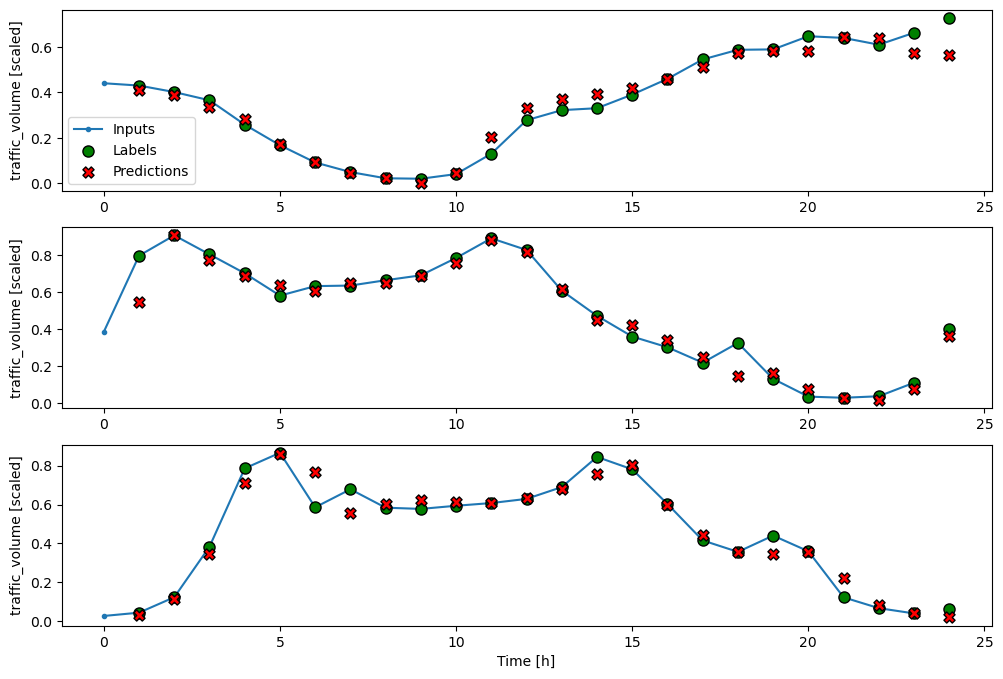

In [26]:
wide_window.plot(lstm_model)

In [27]:
val_perfomance['LSTM'] = lstm_model.evaluate(wide_window.val)
performance['LSTM'] = lstm_model.evaluate(wide_window.test, verbose=0)

109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0017 - mean_absolute_error: 0.0288


Multi-step linear model

In this model, we use 24 hours of data as an input to predict the next 24 hours of traffic volume. We will use 24 hours of data as an input to predict the next 24 hours of traffic volume.

Since our model only has one dense layer, we can initialize the weights to 0 which makes the training procedure slighly faster

In [28]:
multi_window = DataWindow(input_width=24, label_width=24, shift=24, label_columns=['traffic_volume'])

In [33]:
ms_lstm_model = Sequential([
    LSTM(32, return_sequences=True),
    Dense(1, kernel_initializer=tf.initializers.zeros)
])

history = compile_and_fit(ms_lstm_model, multi_window)

ms_val_performance = {}
ms_performance = {}

ms_val_performance['LSTM'] = ms_lstm_model.evaluate(multi_window.val)

ms_performance['LSTM'] = ms_lstm_model.evaluate(multi_window.test, verbose=0)

Epoch 1/50
383/383 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step - loss: 0.0912 - mean_absolute_error: 0.2279 - val_loss: 0.0205 - val_mean_absolute_error: 0.1007
Epoch 2/50
383/383 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 0.0172 - mean_absolute_error: 0.0917 - val_loss: 0.0172 - val_mean_absolute_error: 0.0883
Epoch 3/50
383/383 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 0.0150 - mean_absolute_error: 0.0831 - val_loss: 0.0162 - val_mean_absolute_error: 0.0856
Epoch 4/50
383/383 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 0.0142 - mean_absolute_error: 0.0799 - val_loss: 0.0153 - val_mean_absolute_error: 0.0820
Epoch 5/50
383/383 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 0.0136 - mean_absolute_error: 0.0780 - val_loss: 0.0149 - val_mean_absolute_error: 0.0799
Epoch 6/50
383/383 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 0.0132 - mean_absolute_error: 0.0763 - val_loss: 0.0145 - val_mean_absolute_error: 0.0808
Epoch 7/50
383/383 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 0.0129 - mean_absolute_error: 0.0751 - 

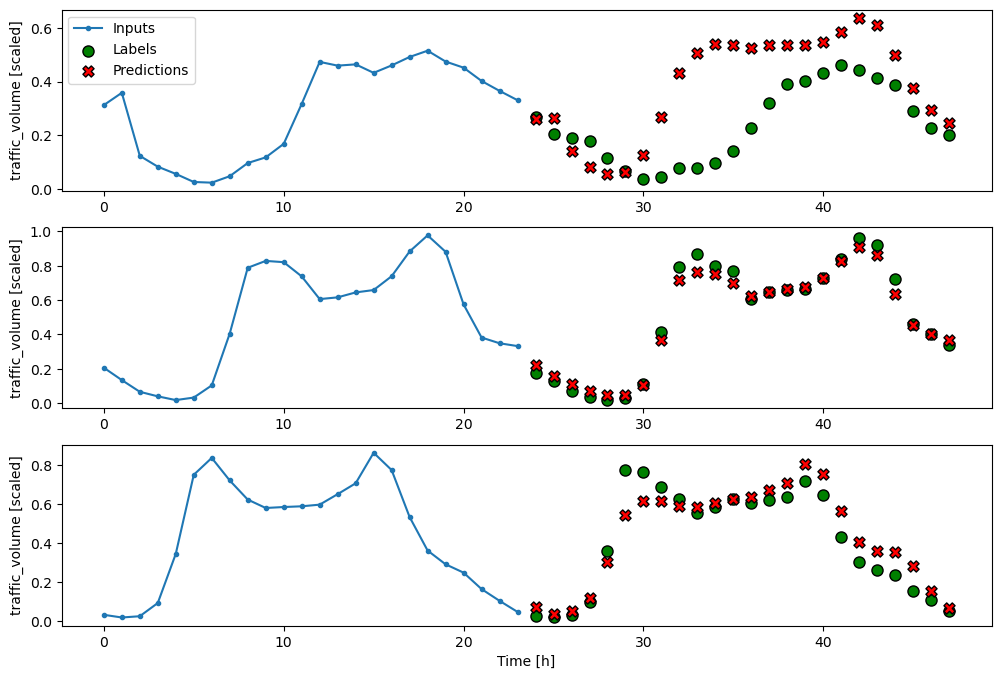

In [34]:
multi_window.plot(ms_lstm_model)

you’ll see that the predictions for the bottom two sequence are very good, as
most predictions overlap the actual values. However, there are some discrepancies
between the output and labels in the top sequence. 

Multi-output model

we’ll use 24 hours
of input data, so that the network can process a sequence of data points and use past
information to produce forecasts. The predictions will be for both the traffic volume
and temperature at the next timestep

In [37]:
mo_single_step_window = DataWindow(input_width=24, label_width=24, shift=1, label_columns=['temp', 'traffic_volume'])

mo_wide_window = DataWindow(input_width=24, label_width=24, shift=1, label_columns=['temp', 'traffic_volume'])

In [35]:
mo_lstm_model = Sequential([
    LSTM(32, return_sequences=True),
    Dense(2)
])

history = compile_and_fit(mo_lstm_model, mo_single_step_window)

mo_val_performance = {}
mo_performance = {}

mo_val_performance['LSTM'] = mo_lstm_model.evaluate(mo_single_step_window.val)

mo_performance['LSTM'] = mo_lstm_model.evaluate(mo_single_step_window.test, verbose=0)

Epoch 1/50
384/384 ━━━━━━━━━━━━━━━━━━━━ 8s 11ms/step - loss: 0.0605 - mean_absolute_error: 0.1730 - val_loss: 0.0104 - val_mean_absolute_error: 0.0685
Epoch 2/50
384/384 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - loss: 0.0079 - mean_absolute_error: 0.0596 - val_loss: 0.0047 - val_mean_absolute_error: 0.0444
Epoch 3/50
384/384 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 0.0043 - mean_absolute_error: 0.0422 - val_loss: 0.0031 - val_mean_absolute_error: 0.0363
Epoch 4/50
384/384 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 0.0032 - mean_absolute_error: 0.0359 - val_loss: 0.0025 - val_mean_absolute_error: 0.0326
Epoch 5/50
384/384 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 0.0027 - mean_absolute_error: 0.0328 - val_loss: 0.0022 - val_mean_absolute_error: 0.0298
Epoch 6/50
384/384 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 0.0025 - mean_absolute_error: 0.0307 - val_loss: 0.0019 - val_mean_absolute_error: 0.0280
Epoch 7/50
384/384 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 0.0022 - mean_absolute_error: 0.0289 -

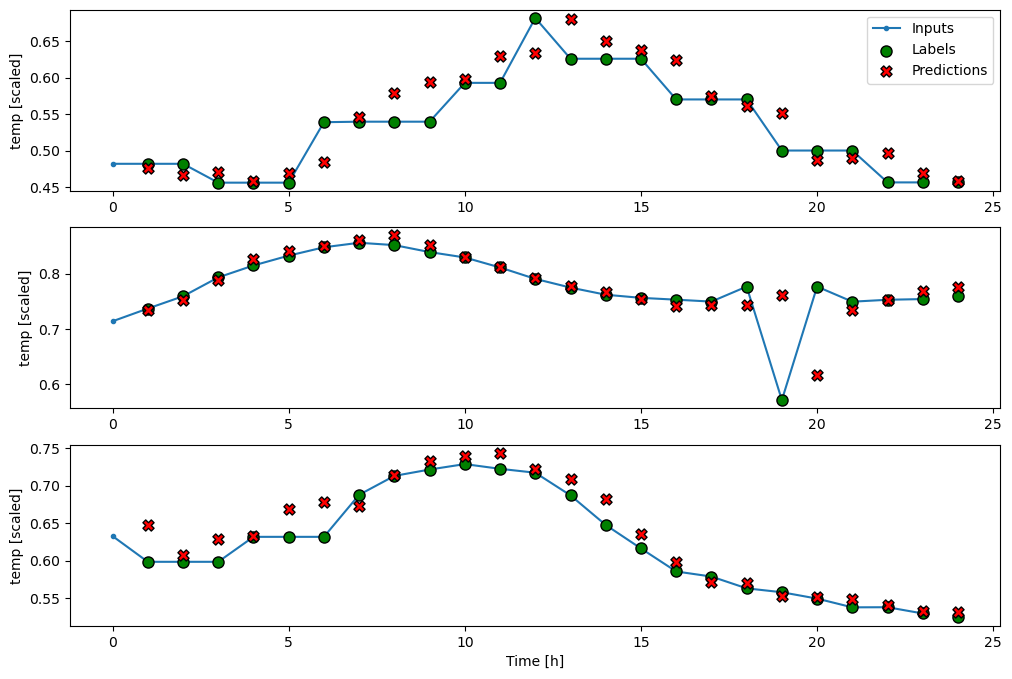

In [38]:
mo_wide_window.plot(model = mo_lstm_model, plot_col = 'temp')

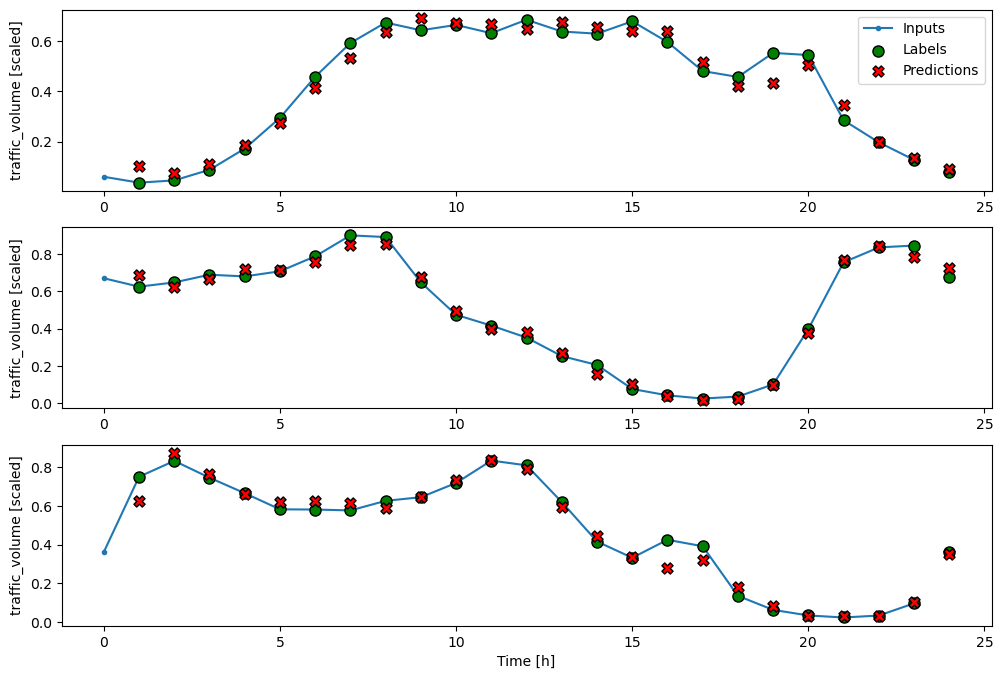

In [39]:
mo_wide_window.plot(model = mo_lstm_model, plot_col = 'traffic_volume')

the LSTM is the winning model, since it achieves the
lowest MAE on the validation and test sets. Thus, it generated the most accurate predictions
so far for both our targets.